In [5]:
import gymnasium as gym
from gym import spaces
import pygame
import numpy as np
import time
import matplotlib.pyplot as plt
import time
import random
import pandas as pd

#Set the seed for reproducibility
np.random.seed(7)
random.seed(7)

In [6]:
train = pd.read_excel("train.xlsx", parse_dates=['PRICES'])
train['month'] = train['PRICES'].dt.month - 1
train['day'] = train['PRICES'].dt.day - 1
train['year'] = train['PRICES'].dt.year
train.head()

,PRICES,Hour 01,Hour 02,Hour 03,Hour 04,Hour 05,Hour 06,Hour 07,Hour 08,Hour 09,...,Hour 18,Hour 19,Hour 20,Hour 21,Hour 22,Hour 23,Hour 24,month,day,year
0,2007-01-01,24.31,24.31,21.71,8.42,0.01,0.01,0.02,0.01,0.01,...,27.77,37.99,33.11,37.99,33.00,36.48,30.65,0,0,2007
1,2007-01-02,16.01,11.00,9.01,7.50,9.00,7.45,16.50,28.01,29.96,...,53.00,59.69,50.09,50.00,36.22,31.09,29.84,0,1,2007
2,2007-01-03,28.00,24.50,24.15,18.99,15.50,23.11,29.01,39.73,43.81,...,57.00,60.99,55.51,51.77,34.51,39.31,38.05,0,2,2007
3,2007-01-04,31.01,28.69,27.00,24.20,12.02,27.00,28.00,34.85,41.31,...,53.00,58.99,53.50,44.01,35.00,34.46,31.57,0,3,2007
4,2007-01-05,22.00,19.50,17.55,15.91,11.40,22.65,27.30,34.00,40.01,...,49.84,53.00,45.91,36.74,29.61,30.61,27.51,0,4,2007


In [50]:
class SmartGridEnv(gym.Env):
    def __init__(self, price_data, battery_capacity=50, max_power=25, efficiency=0.9):
        super(SmartGridEnv, self).__init__()

        self.price_data = price_data
        self.battery_capacity = battery_capacity
        self.max_power = max_power
        self.time_constraint = 7
        self.battery_time_constraint = 20
        self.efficiency = efficiency

        self.current_step = 0
        self.current_month = 0
        self.current_day = 0
        self.current_hour = 0
        self.current_battery = 50  # Initial battery level
        self.current_state = [self.current_step, self.current_month, self.current_day, self.current_hour, self.current_battery]
        self.done = False
        self.profit = 0  # Initial

        # Action space: 0 for buying, 1 for selling, 2 for holding
        self.action_space = gym.spaces.Discrete(51, start=-25)

    def reset(self):
        self.current_step = 0
        self.current_month = 0
        self.current_day = 0
        self.current_hour = 0
        self.current_battery = 50
        self.current_state = [self.current_step, self.current_month, self.current_day, self.current_hour, self.current_battery]
        self.done = False
        self.profit = 0  # Reset profit to 0

    def car_available(self):
        if np.random.uniform(0, 1) < 0.5:
            return True
        self.update_state()
        return False

    def update_state(self):
        # Update time step and hour
        self.current_step += 1
        self.current_month = int(self.price_data.iloc[self.current_step]['month'])
        self.current_day = int(self.price_data.iloc[self.current_step]['day'])
        self.current_hour = int(self.current_step % 24)
    
        # Update state
        self.current_state = [self.current_step, self.current_month, self.current_day, self.current_hour, self.current_battery]

        # Check if the episode is done (after 3 years of past electricity prices)
        if self.current_step >= len(self.price_data) - 1:
            self.done = True

    def step(self, action):
        if self.done:
            raise ValueError("Episode is done. Call reset() to start a new episode.")
    
        # cost  charge
        charge_cost = action * 2 if action > 0 else action
        actual_charge = np.round(self.efficiency * action).astype(int)
        
        # update variables
        self.current_battery += actual_charge
        self.profit += -charge_cost / 1000
        self.update_state()
        
        return self.current_state, -charge_cost, self.done

    # def render(self, mode="human"):
    #     if mode == "human":
    #         if not self.done:
    #             print(f"Step: {self.current_step}, Hour: {self.current_hour}, Battery: {self.current_battery}, Profit: {self.profit}")
    #         else:
    #             print("Episode finished.")
    #     elif mode == "pygame":
    #         self._render_pygame()
    #     elif mode == "rgb_array":
    #         raise NotImplementedError("Rendering as rgb_array is not supported for this environment.")

    # def close(self):
    #     pass

In [53]:
class QAgent():
    def __init__(self, env, discount_rate = 0.95, learning_rate=0.01, epsilon=0.05):
        self.env = env
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.Qtable = np.zeros([12, 31, 24, env.action_space.n]) # month,day,hour,capacity, action_space
        self.profit = []

    def mask(self):
        # 8 am constraint
        if env.current_hour == env.time_constraint and env.current_battery < env.battery_time_constraint:
            buy_range = env.battery_time_constraint - env.current_battery
            mask_range = (buy_range, env.max_power)
                        
        else:
            buy_range = min(env.battery_capacity - env.current_battery, env.max_power)
            sell_range = -min(env.current_battery, env.max_power)
            mask_range = (sell_range, buy_range)

        # constrct boolean mask_vector
        mask = np.arange(env.action_space.start, env.action_space.start + env.action_space.n)
        mask = np.where((mask >= mask_range[0]) & (mask <= mask_range[1]), True, False)
        return mask

    def select_action_epsilon_greedy(self, current_state):
        _, month, day, hour,_ = current_state
        mask = self.mask()
        
        # pick random action
        if (np.random.uniform(0,1) > 1-self.epsilon) or (np.all(self.Qtable[month, day, hour, :] == 0)):
            mask = mask.astype(np.int8)
            action = self.env.action_space.sample(mask=mask).item()
        
        # pick greedy action
        else:
            max_action = np.argmax(self.Qtable[month, day, hour, :][mask])
            action = np.where(mask)[0][0] + max_action

        return action

    def train(self, simulations = 1000, epsilon = 0.05):
        for i in range(simulations):
            while not self.env.done:
                # go next iteration if car not available
                if not env.car_available():
                    continue
    
                current_state = self.env.current_state
                _, month, day, hour,_ = current_state
                
                # select action
                action = self.select_action_epsilon_greedy(current_state)

                # update environment
                next_state, reward, done = env.step(action)
                next_month, next_day, next_hour = next_state[1], next_state[2], next_state[3]
                
                # update Q_values
                Q_target = (reward + self.discount_rate*np.max(self.Qtable[next_month, next_day, next_hour, :]))
                delta = self.learning_rate * (Q_target - self.Qtable[month, day, hour, action])
                self.Qtable[month, day, hour, action] = self.Qtable[month, day, hour, action] + delta

            self.profit.append(env.profit)
            self.env.reset()

    def visulaize_rewards(self):
        # TODO
        pass

    def play_game(self):
        #TODO
        pass

env = SmartGridEnv(train)
agent = QAgent(env)
agent.train(simulations=30)

Text(0.5, 1.0, 'Cost per epoch')

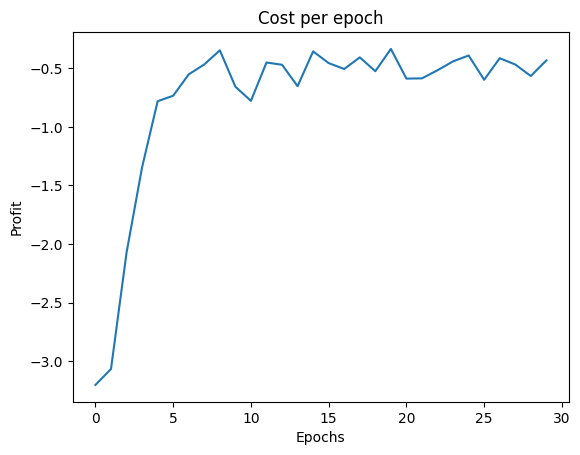

In [55]:
import matplotlib.pyplot as plt
plt.plot(agent.profit)
plt.xlabel('Epochs')  
plt.ylabel('Profit')  
  
# displaying the title 
plt.title("Cost per epoch") 